# Выбор локации для скважины

### Введение

Компания «ГлавРосГосНефть» ставит перед собой задачу выбрать регион для бурения новой скважины. Для этого необходимо определить, в каком из трёх предложенных регионов добыча нефти принесёт наибольшую прибыль. Для решения задачи будут использованы методы машинного обучения, анализа рисков и техники Bootstrap, чтобы предсказать объём запасов нефти, оценить прибыль и риски в каждом регионе.

### Цель исследования

Целью данного проекта является разработка модели, которая поможет выбрать оптимальный регион для бурения скважины, исходя из ожидаемой прибыли и риска. Модель будет обучена на данных о качестве нефти и объёме её запасов, с учётом бюджета компании и стоимости разработки скважин.

### Описание данных

Данные о скважинах в трёх регионах представлены в виде таблиц, в которых для каждой скважины указаны следующие признаки:
- **id**: уникальный идентификатор скважины;
- **f0, f1, f2**: три признака, которые характеризуют различные параметры месторождения;
- **product**: объём запасов нефти в скважине (в тысячах баррелей).

Каждый регион содержит данные о 10 000 месторождениях, и для каждого из них необходимо предсказать объём запасов нефти и выбрать месторождения с наибольшими объёмами для максимальной прибыли.

### Этапы исследования

1. **Подготовка данных**:
   - Загрузка и очистка данных для каждого региона.
   - Преобразование данных в формат, пригодный для машинного обучения.

2. **Обучение и проверка модели**:
   - Разделение данных на обучающую и валидационную выборки в соотношении 75:25.
   - Обучение модели линейной регрессии для каждого региона.
   - Оценка точности модели с использованием RMSE и анализ предсказанных значений.

3. **Расчёт прибыли**:
   - Оценка объёма нефти, необходимого для безубыточной разработки.
   - Выбор месторождений с наибольшими предсказанными объёмами.
   - Расчёт прибыли на основе предсказанных объёмов нефти.

4. **Анализ рисков с использованием техники Bootstrap**:
   - Применение Bootstrap для оценки распределения прибыли по 1000 выборкам.
   - Вычисление средней прибыли, 95%-го доверительного интервала и риска убытков.

5. **Выбор региона**:
   - Определение региона с наибольшей средней прибылью и наименьшим риском убытков (менее 2.5%).
   - Обоснование выбора региона для бурения на основе анализа рисков и прибыли.

В результате выполнения этих шагов будет выбран оптимальный регион для бурения, учитывая все риски и возможности для получения прибыли.

In [1]:
# Импортируем библиотеки и модули
!pip install phik -q 
!pip install -U scikit-learn -q 

import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)

# устанавливаем константы
RANDOM_STATE = 42
test_size=0.25
state = np.random.RandomState(42)
# Параметры
TOTAL_BUDGET = 10**10  # Бюджет на разработку (в тысячах рублей)
REVENUE_PER_UNIT = 450000  # Доход с единицы продукта
BEST_OBJECTS_NUM = 200  # Количество лучших скважин для разработки
CHOOSEN_WELLS = 500  # Количество выбранных скважин для bootstrap
MAX_PROBABILITY_OF_LOSS = 0.025  # Максимально допустимая вероятность убытка


## Загрузка и подготовка данных

In [2]:
# Загрузим данные
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Напишем функцию `info_df(df)`, которая будет выводить полезную информацию о датафрейме. Она выполняет следующие шаги:

1. **Выводит первые строки датафрейма** с помощью `df.head()`, чтобы можно было быстро оценить структуру данных.
2. **Показывает общую информацию** о датафрейме (тип данных и количество ненулевых значений в каждом столбце) через `df.info()`.
3. **Представляет основные статистики для числовых данных**, такие как среднее, стандартное отклонение, минимальные и максимальные значения, а также квартили с помощью `df.describe()`.
4. **Подсчитывает количество дубликатов** в датафрейме с помощью `df.duplicated().sum()`, что позволяет выявить повторяющиеся строки.
5. **Отображает количество пропусков** в каждом столбце с помощью `df.isna().sum()`, чтобы оценить полноту данных.

Эта функция помогает быстро проанализировать структуру, качество и статистику данных.

In [3]:
def info_df(df):
    # Шаг 1: Вывод первых строк датафрейма
    print("Первые строки датафрейма:")
    display(df.head())
    print(" ")
    
    # Шаг 2: Информация о датафрейме
    print("Информация о датафрейме:")
    display(df.info())
    print(" ")
    
    # Шаг 3: Основные статистики числовых данных
    print("Основные статистики числовых данных:")
    display(df.describe().T)
    print(" ")
    
    # Шаг 4: Количество дубликатов
    print("Количество дубликатов в датафрейме:")
    print(df.duplicated().sum())
    
    # Шаг 5: Количество пропусков
    print("Количество пропусков в датафрейме:")
    print(df.isna().sum())

In [4]:
info_df(geo_data_0)

Первые строки датафрейма:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

 
Основные статистики числовых данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [5]:
info_df(geo_data_1)

Первые строки датафрейма:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

 
Основные статистики числовых данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [6]:
info_df(geo_data_2)

Первые строки датафрейма:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

 
Основные статистики числовых данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


### Промежуточные выводы по данным:

1. **Общие характеристики данных:**
   - Все три датасета содержат по 100,000 строк и 5 столбцов: `id`, `f0`, `f1`, `f2`, `product`.
   - Пропуски и дубликаты отсутствуют.
   - Столбец `id` имеет тип `object` и представляет собой уникальные идентификаторы. Остальные столбцы содержат числовые данные типа `float64`.

---

2. **Описание столбцов:**
   - `f0`, `f1`, `f2` — числовые признаки, характеристики месторождений.
   - `product` — целевой признак, объём добычи нефти (в тысячах баррелей).

---

3. **Датасет 1 (`geo_data_0`):**
   - Распределение признаков:
     - `f0`, `f1` и `f2` имеют средние значения около 0 для первых двух признаков и около 2.5 для `f2`.
     - Признак `f2` показывает наибольший разброс: от -12 до 16.
   - Целевой признак:
     - Среднее значение объёма добычи — 92.5.
     - Разброс (стандартное отклонение) — 44.29.
     - Максимальное значение — 185.36.

---

4. **Датасет 2 (`geo_data_1`):**
   - Распределение признаков:
     - Признаки `f0` и `f1` имеют большие диапазоны (например, от -31.6 до 29.4 для `f0`).
     - `f2` отличается меньшим разбросом: от -0.01 до 5.02.
   - Целевой признак:
     - Среднее значение объёма добычи — 68.83, что ниже, чем в других регионах.
     - Разброс — 45.94.
     - Максимальное значение — 137.94.

---

5. **Датасет 3 (`geo_data_2`):**
   - Распределение признаков:
     - Признаки `f0` и `f1` имеют практически нулевые средние значения и сбалансированное распределение.
     - Признак `f2` имеет наиболее широкий диапазон: от -12 до 16.7.
   - Целевой признак:
     - Среднее значение объёма добычи — 95.0.
     - Разброс — 44.75.
     - Максимальное значение — 190.03.

---

6. **Сравнение между датасетами:**
   - Наибольший разброс значений у признаков `f0` и `f1` наблюдается в датасете `geo_data_1`.
   - Датасеты `geo_data_0` и `geo_data_2` имеют схожее распределение целевого признака (`product`), с близкими средними значениями.
   - Наименьший средний объём добычи нефти — в датасете `geo_data_1` (68.83), что может указывать на меньшее среднее содержание ресурсов в этом регионе.

---

**Выводы:**
Данные готовы для дальнейшей обработки и анализа. Необходимо провести исследование взаимосвязи признаков с целевым показателем (`product`) в каждом регионе, чтобы выбрать лучшие стратегии для обучения модели.

### Исследовательский анализ данных

Напишем функцию для автоматического построения графиков:

In [7]:
def numerical_plot(df):
    # Отбираем только числовые столбцы, исключая 'id'
    numeric_df = df.select_dtypes(include='number').drop(columns=['id'], errors='ignore')

    # Для каждого числового столбца строим соответствующие графики
    for col in numeric_df.columns:
        # Определяем, является ли признак дискретным (не более 10 уникальных значений)
        if numeric_df[col].nunique() <= 10:
            # Строим countplot для признаков с менее 20 уникальными значениями
            fig, axes = plt.subplots(ncols=1, figsize=(8, 6))
            sorted_categories = numeric_df[col].value_counts().index
            sns.countplot(y=numeric_df[col], order=sorted_categories, palette='Set2', ax=axes)
            axes.set_title(f'Распределение значений для {col}')
            axes.set_ylabel('Частота')
            axes.set_xlabel(col)
        else:
            # Строим гистограмму и ящичную диаграмму для признаков с более чем 20 уникальными значениями
            fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

            # Гистограмма для визуализации распределения
            sns.histplot(numeric_df[col], kde=True, ax=axes[0], color='skyblue')
            axes[0].set_title(f'Гистограмма для {col}')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Частота')

            # Ящичная диаграмма для распределения
            sns.boxplot(y=numeric_df[col], ax=axes[1], color='lightgreen')
            axes[1].set_title(f'Ящичная диаграмма для {col}')
            axes[1].set_xlabel(col)

        # Отображаем графики
        plt.tight_layout()
        plt.show()

Построим графики для `geo_data_0`:

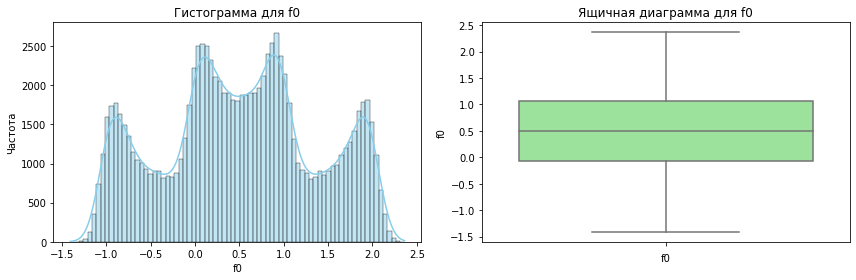

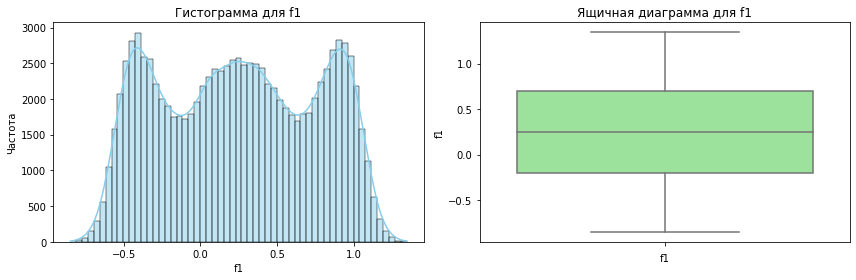

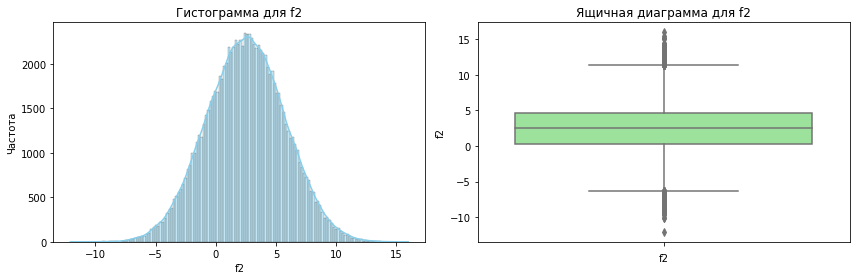

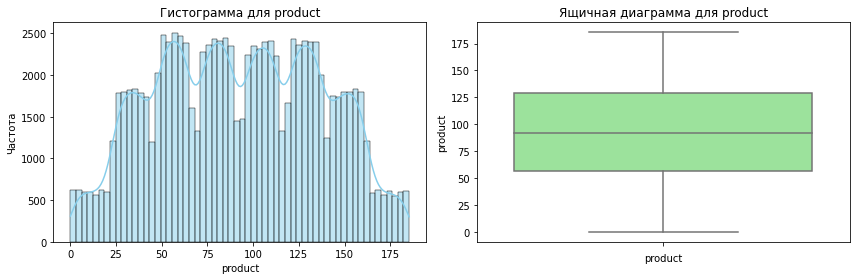

In [8]:
numerical_plot(geo_data_0)

построим графики для `geo_data_1`:

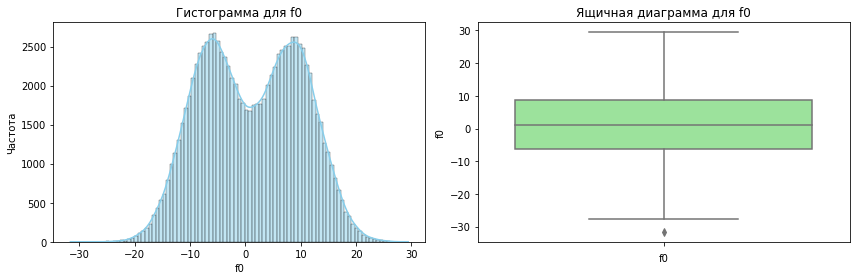

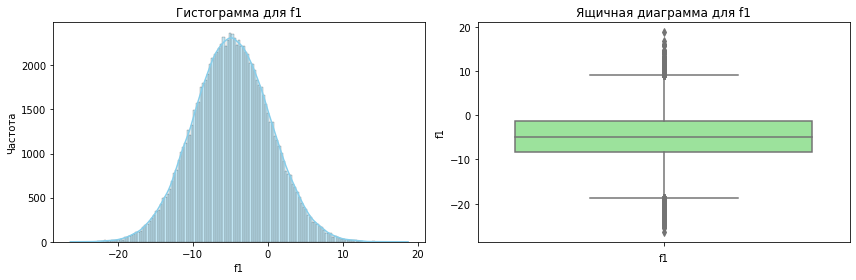

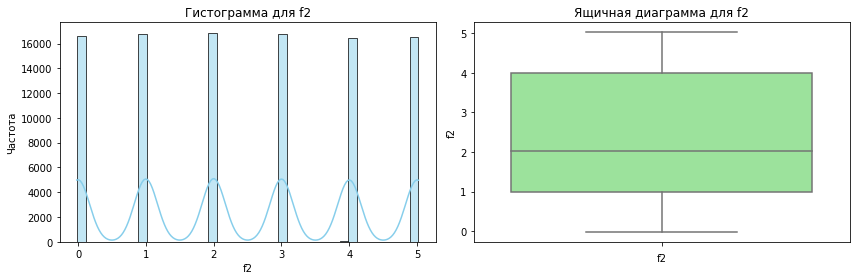

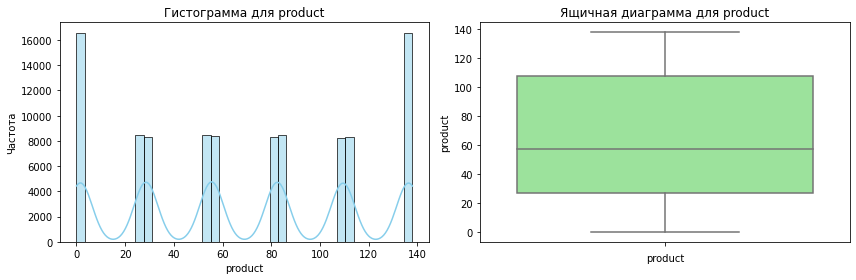

In [9]:
numerical_plot(geo_data_1)

построим графики для `geo_data_2`:

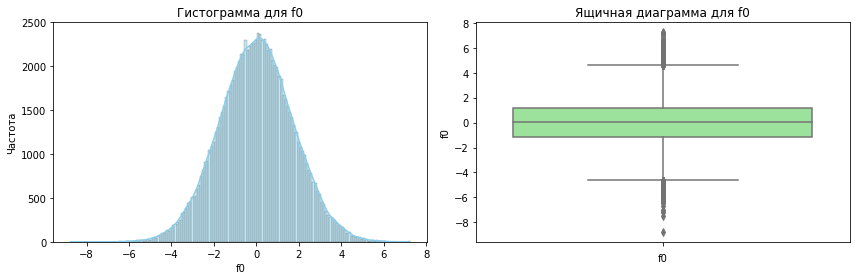

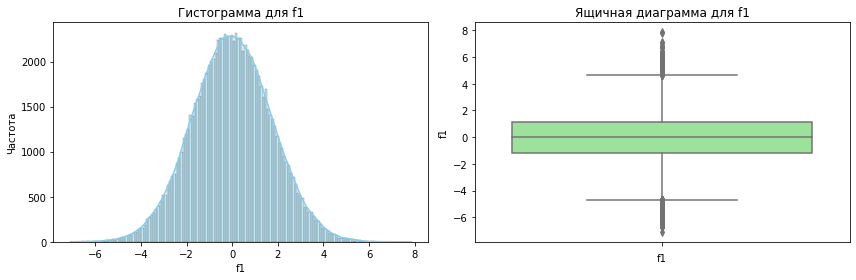

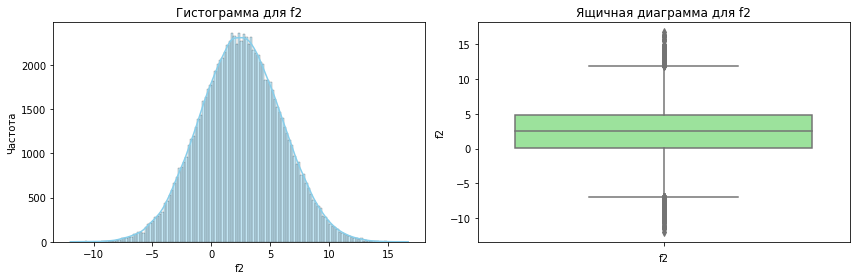

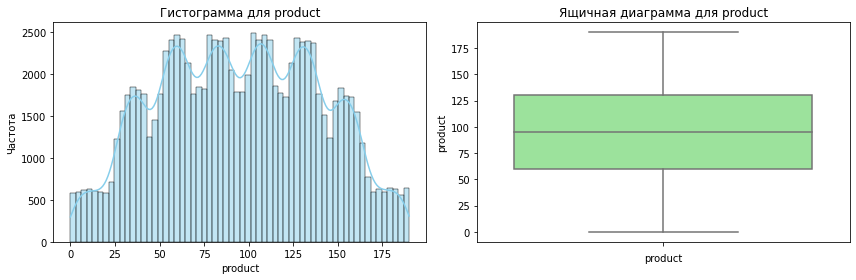

In [10]:
numerical_plot(geo_data_2)

По результатам исследовательского анализа распределения данных, можно сделать следующие выводы для каждого региона:

В **регионе 0** значения признаков **f0**, **f1** и **f2** имеют следующие особенности:
- Признак **f0** имеет среднее значение 0.50, стандартное отклонение 0.87, и диапазон значений от -1.41 до 2.36. Это указывает на умеренную вариативность значений, с концентрацией данных вблизи 0.
- Признак **f1** имеет среднее значение 0.25 и стандартное отклонение 0.50, с диапазоном от -0.85 до 1.34. Эти данные также имеют умеренную вариативность и распределены более равномерно.
- Признак **f2** имеет более широкий диапазон значений от -12.09 до 16.00, что связано с более высоким стандартным отклонением (3.25). Это говорит о большем разбросе данных по этому признаку.
- Целевой признак **product** имеет среднее значение 92.50 и стандартное отклонение 44.29, с диапазоном от 0 до 185.36. Это распределение имеет множество пиков, что может говорить о наличии разных групп или факторов, влияющих на данный показатель.

В **регионе 1** статистики для признаков и целевого признака выглядят несколько иначе:
- Признак **f0** имеет среднее значение 1.14, стандартное отклонение 8.97 и диапазон от -31.61 до 29.42. Это очень широкий диапазон значений, что указывает на наличие значительных аномалий или выбросов.
- Признак **f1** имеет среднее значение -4.80 и стандартное отклонение 5.12, с диапазоном от -26.36 до 18.73. Распределение признака также весьма асимметричное, что может указывать на нестандартное поведение данных.
- Признак **f2** находитсчя в диапазоне от -0.02 до 5.02 и стандартным отклонением 1.70.
- Целевой признак **product** имеет среднее значение 68.83 и стандартное отклонение 45.94, с диапазоном от 0 до 137.95. Распределение **product** в этом регионе отличается от других, возможно, из-за наличия искусственно созданных или дискретных данных, что стоит проверить и учесть при анализе.

В **регионе 2** данные выглядят более симметрично, но также имеют свои особенности:
- Признак **f0** имеет очень низкое среднее значение (0.00) и стандартное отклонение 1.73, с диапазоном от -8.76 до 7.24. Это также свидетельствует о значительном разбросе данных.
- Признак **f1** имеет среднее значение -0.00 и стандартное отклонение 1.73, с диапазоном от -7.08 до 7.84. Это распределение также указывает на некоторую симметричность, но данные все равно имеют широкий диапазон.
- Признак **f2** в этом регионе имеет стандартное отклонение 3.47 и диапазон от -11.97 до 16.74, что говорит о значительном разбросе данных, схожем с **f2** в других регионах.
- Целевой признак **product** в **регионе 2** имеет среднее значение 95.00 и стандартное отклонение 44.75, с диапазоном от 0 до 190.03. Это распределение с несколькими пиками, что может быть связано с более широкими значениями, чем в других регионах.

В целом, **регион 1** выделяется необычным распределением данных, особенно для признака **product**, который имеет явные признаки дискретности и возможно был искусственно введен. В то время как **регионы 0** и **2** демонстрируют более традиционные распределения, с нормальными или близкими к нормальным формами для большинства признаков.

Напишем функцию для построения матрицы корреляции:

In [11]:
def plot_corr_matrix(data, interval_cols):
    """
    Строит корреляционную матрицу PhiK для исходных данных до кодирования и разделения.

    Parameters:
        data (pd.DataFrame): Входной датафрейм.
        interval_cols (list): Список названий числовых (интервальных) признаков для расчета корреляции.
    """

    # 1. Расчет корреляционной матрицы PhiK для всех признаков (кроме 'id') с использованием PhiK
    phik_corr_matrix = data.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

    # 2. Создание маски для верхней треугольной части матрицы, чтобы избежать повторного отображения значений
    mask = np.triu(np.ones_like(phik_corr_matrix, dtype=bool))

    # 3. Настройка графика
    plt.figure(figsize=(15, 8))

    # 4. Визуализация корреляционной матрицы с помощью тепловой карты
    sns.heatmap(phik_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)

    # 5. Добавление заголовка графика
    plt.title("Корреляционная матрица (PhiK)")

    # 6. Отображение графика
    plt.show()
    
    # 7. Вывод таблицы корреляции в консоль
    print("Корреляционная матрица PhiK:")
    display(phik_corr_matrix)

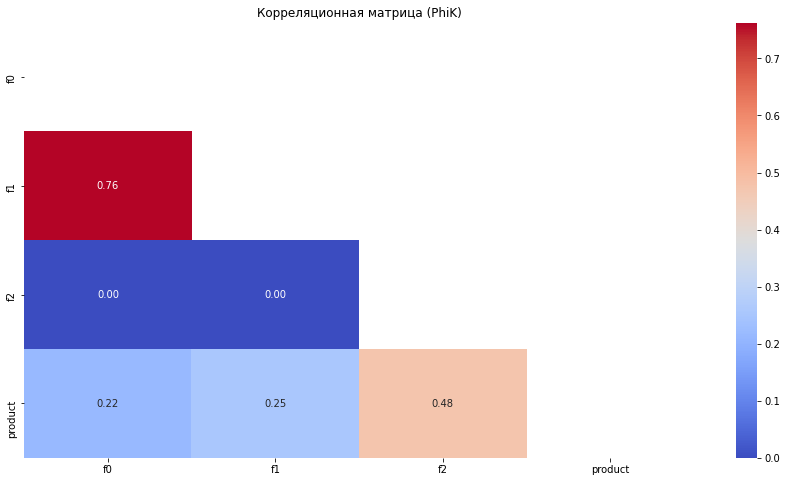

Корреляционная матрица PhiK:


,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


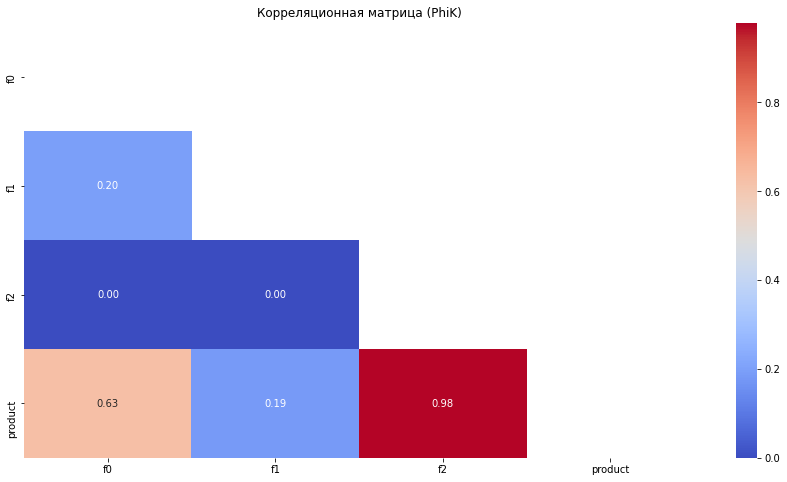

Корреляционная матрица PhiK:


,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


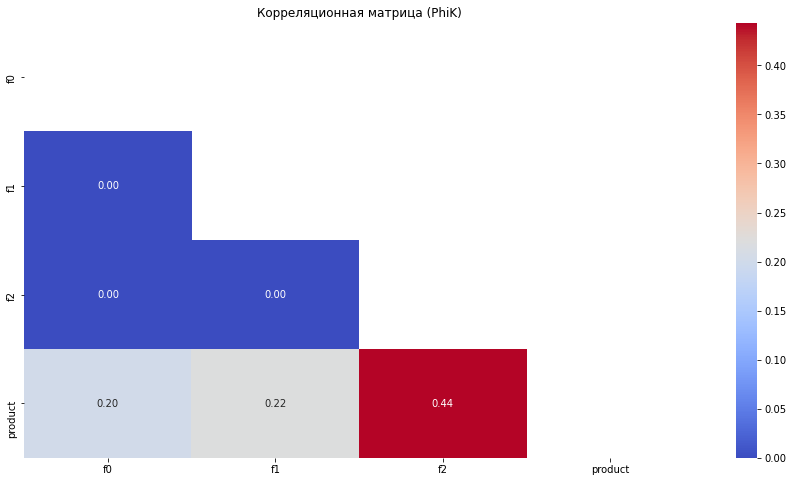

Корреляционная матрица PhiK:


,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


In [12]:
interval_cols = ['f0','f1', 'f2', 'product']
plot_corr_matrix(geo_data_0, interval_cols)
plot_corr_matrix(geo_data_1, interval_cols)
plot_corr_matrix(geo_data_2, interval_cols)

**Промежуточный вывод:**

В результате анализа корреляции признаков с целевым параметром в разных регионах можно сделать следующие выводы. В **регионе 0** наибольшую корреляцию с целевым признаком "product" показывает признак **f2** (коэффициент 0.48), что указывает на умеренное влияние этого признака на объем продукта. Признаки **f0** и **f1** также имеют слабую положительную корреляцию с "product" (0.22 и 0.25 соответственно), что свидетельствует о менее значимом влиянии этих признаков на объем продукции.

В **регионе 1** корреляция между признаком **f2** и "product" очень сильная (0.98), что говорит о почти полной зависимости объема продукта от этого признака. Признак **f0** также имеет умеренную положительную корреляцию с "product" (0.63), тогда как корреляция с **f1** намного слабее (0.19).

В **регионе 2** признак **f2** снова показывает умеренную корреляцию с "product" (0.44), но в целом, связь с целевым признаком слабее, чем в других регионах. Признаки **f0** и **f1** имеют слабую положительную корреляцию с "product" (0.20 и 0.22 соответственно), что также указывает на их меньшую роль в предсказаниях объема продукта.

Таким образом, в **регионе 1** объем продукта почти полностью зависит от признака **f2**, в то время как в других регионах наиболее сильное влияние на объем продукта оказывает этот же признак, но с более умеренной корреляцией.

### Подготовка признаков

Установим 'id' в качестве индекса для наших выборок, и обязательно проверим не появились ли дубликаты после переноса 'id' в индекс:

In [13]:
# Индексируем тестовую выборку с использованием 'id'
geo_data_0 = geo_data_0.set_index('id')
geo_data_0.duplicated().sum()

0

In [14]:
# Индексируем тестовую выборку с использованием 'id'
geo_data_1 = geo_data_1.set_index('id')
geo_data_1.duplicated().sum()

0

In [15]:
# Индексируем тестовую выборку с использованием 'id'
geo_data_2 = geo_data_2.set_index('id')
geo_data_2.duplicated().sum()

0

Отлично! Выборки проиндексированы, повторяющихся элементов после индексации не обнаружено.
Выполним выделение признаков (X) и целевого признака (y) для каждого региона. Затем разделим данные на обучающую и валидационную выборки в соотношении 75:25. После разделения выведем размеры выборок для каждого региона, чтобы убедиться в корректности выполнения.

In [16]:
# Выделение признаков (X) и целевого признака (y) для каждого региона

# Для первого региона
X_0 = geo_data_0.drop(columns='product')
y_0 = geo_data_0['product']

# Для второго региона
X_1 = geo_data_1.drop(columns='product')
y_1 = geo_data_1['product']

# Для третьего региона
X_2 = geo_data_2.drop(columns='product')
y_2 = geo_data_2['product']

# Разделение данных на train и valid для каждого региона
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(X_0, y_0, test_size=test_size, random_state=RANDOM_STATE)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1, y_1, test_size=test_size, random_state=RANDOM_STATE)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2, y_2, test_size=test_size, random_state=RANDOM_STATE)

# Вывод размерностей выборок
print("Размерности выборок после разделения:")
print(f"Регион 0: X_train: {X_train_0.shape}, X_valid: {X_valid_0.shape}, y_train: {y_train_0.shape}, y_valid: {y_valid_0.shape}")
print(f"Регион 1: X_train: {X_train_1.shape}, X_valid: {X_valid_1.shape}, y_train: {y_train_1.shape}, y_valid: {y_valid_1.shape}")
print(f"Регион 2: X_train: {X_train_2.shape}, X_valid: {X_valid_2.shape}, y_train: {y_train_2.shape}, y_valid: {y_valid_2.shape}")


Размерности выборок после разделения:
Регион 0: X_train: (75000, 3), X_valid: (25000, 3), y_train: (75000,), y_valid: (25000,)
Регион 1: X_train: (75000, 3), X_valid: (25000, 3), y_train: (75000,), y_valid: (25000,)
Регион 2: X_train: (75000, 3), X_valid: (25000, 3), y_train: (75000,), y_valid: (25000,)


Размерности совпадают, приступим к обучению модели.

## Обучение и проверка модели

Выполним стандартизацию данных для каждого региона с использованием `StandardScaler`, чтобы привести признаки к единой шкале. После этого обучим модели линейной регрессии для каждого региона на стандартизированных данных. Для оценки качества моделей рассчитаем метрику RMSE (корень из среднеквадратичной ошибки) и выведем средние предсказанные значения объема сырья. Результаты позволят оценить точность предсказаний для каждого региона.

In [17]:
# Функция для обучения модели, вычисления метрик и подготовки результатов
def train_and_evaluate_model(region, X_train, X_valid, y_train, y_valid):
    # Создание объектов StandardScaler и LinearRegression
    scaler = StandardScaler()
    model = LinearRegression()

    # Стандартизация данных
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Предсказания
    predictions = model.predict(X_valid_scaled)

    # Метрики
    mse = mean_squared_error(y_valid, predictions)
    rmse = mse ** 0.5

    # Создание результата
    results = pd.DataFrame({'y_valid': y_valid, 'predictions': predictions})

    # Вывод результатов
    print(f"Результаты модели для региона {region}:")
    print(f"Средний предсказанный объем продукта: {predictions.mean():.2f}")
    print(f"Средний фактический объем продукта: {y_valid.mean():.2f}")
    print(f"RMSE: {rmse:.2f}")
    print()

    return model, scaler, results, rmse



In [18]:
# Список данных для регионов
regions_data = [
    (0, X_train_0, X_valid_0, y_train_0, y_valid_0),
    (1, X_train_1, X_valid_1, y_train_1, y_valid_1),
    (2, X_train_2, X_valid_2, y_train_2, y_valid_2),
]

# Переменные для хранения результатов
models = []
scalers = []
results_list = []
rmses = []

# Цикл по регионам
for region, X_train, X_valid, y_train, y_valid in regions_data:
    model, scaler, results, rmse = train_and_evaluate_model(region, X_train, X_valid, y_train, y_valid)
    models.append(model)
    scalers.append(scaler)
    results_list.append(results)
    rmses.append(rmse)

# Разворачивание результатов по регионам
model_0, model_1, model_2 = models
scaler_0, scaler_1, scaler_2 = scalers
results_0, results_1, results_2 = results_list
rmse_0, rmse_1, rmse_2 = rmses


Результаты модели для региона 0:
Средний предсказанный объем продукта: 92.40
Средний фактический объем продукта: 92.33
RMSE: 37.76

Результаты модели для региона 1:
Средний предсказанный объем продукта: 68.71
Средний фактический объем продукта: 68.73
RMSE: 0.89

Результаты модели для региона 2:
Средний предсказанный объем продукта: 94.77
Средний фактический объем продукта: 95.15
RMSE: 40.15



**Промежуточный вывод:**


Модель для региона 1 демонстрирует наивысшую точность предсказаний, что подтверждается самым низким значением RMSE (0.89). Средний предсказанный объем продукта (68.71 тыс. баррелей) практически совпадает со средним фактическим объемом (68.73 тыс. баррелей).  

В регионах 0 и 2 наблюдаются более высокие средние предсказанные объемы продукта (92.40 и 94.77 тыс. баррелей соответственно), однако значения RMSE для этих регионов значительно выше (37.76 и 40.15), что указывает на большие ошибки в предсказаниях.  

Таким образом, регион 1 выглядит предпочтительным с точки зрения точности модели, что может стать ключевым фактором для дальнейшего анализа и принятия решений.

## Подготовка к расчёту прибыли

Посчитаем минимально необходимый объём сырья на одну скважину для безубыточной разработки. Для этого используем следующие параметры: общий бюджет на разработку, доход с единицы сырья и количество лучших скважин для разработки. Мы делим общий бюджет на произведение дохода с одного барреля и количества скважин, чтобы определить минимально необходимый объём сырья, который должен быть извлечён из каждой скважины для обеспечения безубыточности проекта.

Результат покажет, сколько тысяч баррелей сырья нужно получить с каждой скважины для того, чтобы проект был прибыльным.

In [19]:
# Расчёт минимального объёма сырья для безубыточной разработки на одну скважину
required_volume_per_well = TOTAL_BUDGET / (REVENUE_PER_UNIT * BEST_OBJECTS_NUM)
print(f"Минимальный объём сырья на одну скважину для безубыточной разработки: {required_volume_per_well:.2f} тыс. баррелей")

Минимальный объём сырья на одну скважину для безубыточной разработки: 111.11 тыс. баррелей


In [20]:
# Средние значения целевой переменной и предсказаний для каждого региона
avg_target_0 = results_0['y_valid'].mean()
avg_target_1 = results_1['y_valid'].mean()
avg_target_2 = results_2['y_valid'].mean()

avg_predictions_0 = results_0['predictions'].mean()
avg_predictions_1 = results_1['predictions'].mean()
avg_predictions_2 = results_2['predictions'].mean()

# Минимально необходимый объём сырья для безубыточной разработки
print(f"Минимальный объём сырья на одну скважину для безубыточной разработки: {required_volume_per_well:.2f} тыс. баррелей\n")

# Печатаем средние значения и делаем сравнение
print("Средние значения и сравнение с безубыточным объёмом:\n")

print(f"Регион 0:")
print(f"Среднее фактическое значение: {avg_target_0:.2f} тыс. баррелей")
print(f"Среднее предсказанное значение: {avg_predictions_0:.2f} тыс. баррелей")
print(f"{'Достаточно' if avg_target_0 >= required_volume_per_well else 'Недостаточно'} сырья для безубыточной разработки\n")

print(f"Регион 1:")
print(f"Среднее фактическое значение: {avg_target_1:.2f} тыс. баррелей")
print(f"Среднее предсказанное значение: {avg_predictions_1:.2f} тыс. баррелей")
print(f"{'Достаточно' if avg_target_1 >= required_volume_per_well else 'Недостаточно'} сырья для безубыточной разработки\n")

print(f"Регион 2:")
print(f"Среднее фактическое значение: {avg_target_2:.2f} тыс. баррелей")
print(f"Среднее предсказанное значение: {avg_predictions_2:.2f} тыс. баррелей")
print(f"{'Достаточно' if avg_target_2 >= required_volume_per_well else 'Недостаточно'} сырья для безубыточной разработки\n")


Минимальный объём сырья на одну скважину для безубыточной разработки: 111.11 тыс. баррелей

Средние значения и сравнение с безубыточным объёмом:

Регион 0:
Среднее фактическое значение: 92.33 тыс. баррелей
Среднее предсказанное значение: 92.40 тыс. баррелей
Недостаточно сырья для безубыточной разработки

Регион 1:
Среднее фактическое значение: 68.73 тыс. баррелей
Среднее предсказанное значение: 68.71 тыс. баррелей
Недостаточно сырья для безубыточной разработки

Регион 2:
Среднее фактическое значение: 95.15 тыс. баррелей
Среднее предсказанное значение: 94.77 тыс. баррелей
Недостаточно сырья для безубыточной разработки



**Промежуточный вывод:**

Минимально необходимый объём сырья для безубыточной разработки составляет 111.11 тыс. баррелей на одну скважину. При сравнении с фактическими и предсказанными средними значениями объёма сырья для каждого региона можно сделать следующие выводы:

1. **Регион 0:**  
   Среднее фактическое значение объёма сырья составляет 92.33 тыс. баррелей, а среднее предсказанное — 92.40 тыс. баррелей. Эти значения ниже минимального порога безубыточности, что означает, что для достижения безубыточности в регионе потребуется тщательный выбор лучших скважин с наибольшим объёмом сырья.

2. **Регион 1:**  
   Среднее фактическое значение объёма сырья — 68.73 тыс. баррелей, среднее предсказанное — 68.71 тыс. баррелей. Обе оценки также ниже требуемого уровня, что подчёркивает важность отборочных критериев для выбора наиболее перспективных скважин.

3. **Регион 2:**  
   Среднее фактическое значение составляет 95.15 тыс. баррелей, а среднее предсказанное — 94.77 тыс. баррелей. Несмотря на то что эти показатели ближе к минимальному требованию, их всё равно недостаточно для безубыточности. Необходим тщательный отбор скважин с большими запасами для успешной разработки.

**Общий вывод:**  
Для успешной разработки в каждом из регионов необходимо провести более тщательный отбор скважин с большими объёмами сырья. Это позволит значительно повысить вероятность безубыточности и обеспечить более эффективное использование имеющихся ресурсов.

## Расчёт прибыли и рисков 

Посчитаем прибыль для выбранных скважин с использованием техники бутстрэп. Мы выберем 500 скважин (CHOOSEN_WELLS) для случайных выборок и определим прибыль, основываясь на 200 лучших предсказанных значениях объёма сырья (BEST_OBJECTS_NUM). Для этого отсортируем данные по предсказанным объёмам сырья и просуммируем значения, соответствующие этим скважинам. Полученную сумму умножим на доход с одного барреля (REVENUE_PER_UNIT) и вычтем общий бюджет на разработку (TOTAL_BUDGET), чтобы рассчитать прибыль.

In [21]:
# Функция для расчёта прибыли
def profit_calc(result):
    # Сортировка по предсказанным значениям (по убыванию)
    result_200 = result.sort_values(by='predictions', ascending=False).head(BEST_OBJECTS_NUM)
    
    # Расчёт прибыли
    profit = (result_200['y_valid'].sum() * REVENUE_PER_UNIT) - TOTAL_BUDGET
    return profit

Для оценки доходности и рисков применим метод бутстрэп с 1000 итераций. В каждой итерации будем случайным образом выбирать 500 скважин (CHOOSEN_WELLS) с возвращением из исходных данных и рассчитывать прибыль для этих скважин. Затем вычислим средний доход, а также 95% доверительный интервал для прибыли. Рассчитаем вероятность убытка как долю случаев с отрицательной прибылью. Результаты помогут оценить ожидаемую прибыль и риски для каждого региона.

In [22]:
# Функция для расчёта доходов и убытков
def profit_and_loss(result):
    # Создание датафрейма с целевыми значениями и предсказаниями

    # Значение для random_state
    state = np.random.RandomState(42)
    
    # Массив доходности после применения техники бутстрэп
    profit_bootstrap = []
    
    # Применение бутстрэп (1000 итераций)
    for i in range(1000):
        # Случайная выборка с возвращением
        result_sample = result.sample(n=CHOOSEN_WELLS, replace=True, random_state=state)
        
        # Расчет прибыли для выборки
        profit_bootstrap.append(profit_calc(result_sample))
    
    # Преобразуем список в pandas Series для удобства вычислений
    profit_bootstrap = pd.Series(profit_bootstrap)
    
    # Средний доход (в миллионах рублей)
    mean_profit = profit_bootstrap.mean() / 1_000_000  # Переводим в миллионы
    mean_profit = round(mean_profit, 2)  # Округление до 2 знаков после запятой
    
    # Нижний и верхний квантиль (95% доверительный интервал)
    lower_profit = profit_bootstrap.quantile(0.025) / 1_000_000  # Переводим в миллионы
    upper_profit = profit_bootstrap.quantile(0.975) / 1_000_000  # Переводим в миллионы
    
    # Вероятность убытка
    probability_of_loss = (profit_bootstrap < 0).mean()
    
    print(f'95% доверительный интервал доходности находится в пределах от {round(lower_profit, 2)} до {round(upper_profit, 2)} млн рублей')
    print(f'Средний доход     : {mean_profit} млн рублей')
    print(f'Вероятность убытка: {probability_of_loss * 100}%')
    
    return mean_profit, probability_of_loss

# Массив для хранения средней доходности и вероятности убытков
mean_profits = []
probabilities_of_losses = []

# Расчет прибыли и рисков для каждого региона

# Регион 0
print('Регион 0')
mean_profit, probability_of_loss = profit_and_loss(results_0)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probability_of_loss)
print('')

# Регион 1
print('Регион 1')
mean_profit, probability_of_loss = profit_and_loss(results_1)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probability_of_loss)
print('')

# Регион 2
print('Регион 2')
mean_profit, probability_of_loss = profit_and_loss(results_2)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probability_of_loss)

Регион 0
95% доверительный интервал доходности находится в пределах от -110.47 до 897.46 млн рублей
Средний доход     : 399.58 млн рублей
Вероятность убытка: 6.0%

Регион 1
95% доверительный интервал доходности находится в пределах от 61.68 до 845.34 млн рублей
Средний доход     : 452.05 млн рублей
Вероятность убытка: 1.5%

Регион 2
95% доверительный интервал доходности находится в пределах от -144.77 до 888.39 млн рублей
Средний доход     : 375.01 млн рублей
Вероятность убытка: 8.0%


Для выбора региона для инвестиций мы сначала фильтруем регионы с допустимой вероятностью убытков (менее 2,5%). Затем среди оставшихся регионов выбираем тот, который имеет наибольшую ожидаемую прибыль. После этого выводим информацию о выбранном регионе, включая его доходность и вероятность убытка, чтобы помочь принять обоснованное решение о вложениях.

In [23]:
# Выводы расчета прибыли и рисков
mppl_df = pd.DataFrame({
    'profit': mean_profits, 
    'probability_of_loss': probabilities_of_losses
})

# Отбираем только регионы с допустимой вероятностью убытков
mppl_df = mppl_df.loc[mppl_df['probability_of_loss'] < MAX_PROBABILITY_OF_LOSS]

# Выбираем регион с наибольшей прибылью среди оставшихся
mppl_df = mppl_df.loc[mppl_df['profit'] == mppl_df['profit'].max()]

# Нумерация для вывода
num = {0: 'нулевой', 1: 'первый', 2: 'второй'}

# Печатаем результат
print(f"Для инвестирования предлагается выбрать {num[mppl_df.index[0]]} регион. "
      f"В этом регионе ожидаемая доходность {mppl_df.loc[mppl_df.index[0], 'profit']} млн рублей, "
      f"а вероятность убытка {mppl_df.loc[mppl_df.index[0], 'probability_of_loss'] * 100}%. "
      f"Среди регионов с вероятностью убытка, находящегося "
      f"в пределах допустимого значения {MAX_PROBABILITY_OF_LOSS * 100}%, "
      f"в данном регионе самая высокая ожидаемая прибыль.")


Для инвестирования предлагается выбрать первый регион. В этом регионе ожидаемая доходность 452.05 млн рублей, а вероятность убытка 1.5%. Среди регионов с вероятностью убытка, находящегося в пределах допустимого значения 2.5%, в данном регионе самая высокая ожидаемая прибыль.


**Итоговый вывод:**

Цели проекта достигнуты, и был выбран оптимальный регион для инвестирования. Этот выбор основан на глубоком анализе рисков и прибыли, с учётом полученных результатов. В процессе выполнения проекта были решены следующие задачи:

1. **Загрузка и подготовка данных**. Для начала были собраны и загружены данные по каждому региону. Затем данные были обработаны: были проверены дубликаты, установлены индексы, выделены необходимые признаки для дальнейшего анализа и разделения на обучающую и валидационную выборки.

2. **Обучение и проверка моделей**. Для каждого региона была построена модель линейной регрессии, которая позволила прогнозировать объемы добычи. Для каждой модели была рассчитана метрика RMSE, которая показала точность предсказаний. Модели были обучены и проверены на стандартизированных данных, что позволило получить более точные прогнозы.
Модель для региона 1 демонстрирует наивысшую точность предсказаний, что подтверждается самым низким значением RMSE (0.89). Средний предсказанный объем продукта (68.71 тыс. баррелей) практически совпадает со средним фактическим объемом (68.73 тыс. баррелей). В регионах 0 и 2 наблюдаются более высокие средние предсказанные объемы продукта (92.40 и 94.77 тыс. баррелей соответственно), однако значения RMSE для этих регионов значительно выше (37.76 и 40.15), что указывает на большие ошибки в предсказаниях.
Таким образом, регион 1 выглядит предпочтительным с точки зрения точности модели, что может стать ключевым фактором для дальнейшего анализа и принятия решений.

3. **Подготовка к расчёту прибыли**. Была определена точка безубыточности для каждой скважины. На основе полученных предсказаний была создана функция для расчета прибыли в лучших месторождениях. 
Минимально необходимый объём сырья для безубыточной разработки составляет 111.11 тыс. баррелей на одну скважину. При сравнении фактических и предсказанных средних значений объёма сырья для каждого региона было установлено, что:
•	В регионе 0 средние фактические и предсказанные значения объёма сырья (92.33 тыс. и 92.40 тыс. баррелей) ниже минимального порога. Это указывает на необходимость тщательного выбора лучших скважин с большими объёмами для обеспечения безубыточности.
•	В регионе 1 средние фактические и предсказанные значения (68.73 тыс. и 68.71 тыс. баррелей) также ниже минимального объёма. Необходимо также сосредоточиться на отборе скважин с большим объёмом.
•	В регионе 2 средние значения объёма сырья (95.15 тыс. и 94.77 тыс. баррелей) приближаются к требуемому минимуму, но для обеспечения безубыточности тоже следует выбрать наиболее перспективные скважины с более высокими запасами.

4. **Расчёт рисков и прибыли для каждого региона**. Используя технику бутстрэп, были смоделированы доходность и вероятность убытка. Для каждого региона были вычислены средняя прибыль, вероятности убытков и доверительные интервалы. Это позволило объективно оценить наилучший вариант для инвестирования.

Для всех регионов требуется тщательно отбирать скважины с наиболее высокими запасами, чтобы обеспечить безубыточность разработки. Это подчеркивает важность анализа и выбора лучших объектов для инвестирования.
В результате исследования для инвестирования рекомендуется выбрать первый регион, так как он демонстрирует наибольшую ожидаемую прибыль среди всех регионов, которые соответствуют установленному порогу риска убытков. Ожидаемая доходность в этом регионе составляет 452,05 млн рублей, что является наивысшим результатом среди всех анализируемых регионов. При этом вероятность убытка в регионе составляет всего 1,5%, что значительно ниже максимально допустимой вероятности убытка в 2,5%. Это означает, что первый регион не только имеет наибольшую прибыль, но и низкий риск финансовых потерь, что делает его наиболее привлекательным для инвестиций.

Рекомендации:
1. **Сосредоточить инвестиции на первом регионе**. На основании анализа, первый регион демонстрирует наибольшую ожидаемую прибыль и низкий риск убытков. Это делает его наиболее выгодным для разработки скважин.

2. **Провести дополнительную оценку рисков в других регионах**. Хотя первый регион является наилучшим вариантом, стоит также провести более глубокий анализ других регионов, чтобы выявить возможные скрытые возможности или улучшить точность прогнозов.

3. **Мониторинг и улучшение качества прогнозов**. Постоянно обновлять модели на основе новых данных и улучшать точность предсказаний, чтобы своевременно реагировать на изменения в экономических и природных условиях.

4. **Диверсификация портфеля**. Рассмотреть возможность распределения инвестиций между несколькими регионами, чтобы снизить риски и обеспечить стабильную прибыль в случае изменений в конкретном регионе.

5. **Риски, связанные с внешними факторами**. Необходимо учитывать возможные изменения в законодательстве, ценах на нефть, экологические факторы и другие внешние риски, которые могут повлиять на рентабельность проектов.

6. **Использование инновационных технологий**. Внедрение современных технологий для повышения эффективности разработки скважин, таких как автоматизация процессов, улучшение методов добычи и мониторинга, может дополнительно повысить прибыльность и уменьшить риски.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован